In [1]:
# Hücre 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Kütüphaneler yüklendi")

✅ Kütüphaneler yüklendi


In [2]:
# Hücre 2: Veri hazırlığı (02_regression.ipynb'den kopyala)
df = pd.read_csv('analyze data.csv', index_col=0)

df_country_median = (
    df.groupby(["country_code","country_name"], as_index=False)
      .agg({
          'child_employment_rate': 'median',
          'log_child_employment_rate': 'median',
          'log_gdp_per_capita_ppp': 'median',
          'agriculture_value_added_pct': 'median',
          'primary_school_enrollment': 'median',
          'life_expectancy': 'median',
          'urban_population_pct': 'median',
          'rural_electricity_access': 'median',
          'child_population_pct': 'median',
          'youth_unemployment_rate': 'median',
          'log_private_consumption_per_capita': 'median',
          'governance_index': 'median'
      })
) #✅ Purpose: To reduce random fluctuations in the time series and represent the country's typical 
  #level.


#  Interaction terms

# Does governance combined with GDP per capita impact child employment?
df_country_median['governance_x_gdp'] = (df_country_median['governance_index'] * 
                                         df_country_median['log_gdp_per_capita_ppp'])
# Do urbanization and agriculture jointly influence child employment?
df_country_median['urban_x_agriculture'] = (df_country_median['urban_population_pct'] * 
                                            df_country_median['agriculture_value_added_pct'])

# Does education combined with governance impact child employment?
df_country_median['education_x_governance'] = (df_country_median['primary_school_enrollment'] * 
                                               df_country_median['governance_index'])

base_features = [
    'log_gdp_per_capita_ppp', 'agriculture_value_added_pct', 'primary_school_enrollment',
    'life_expectancy', 'urban_population_pct', 'rural_electricity_access', 'child_population_pct',
    'youth_unemployment_rate', 'log_private_consumption_per_capita', 'governance_index',
    'governance_x_gdp', 'urban_x_agriculture', 'education_x_governance'
]

target = 'log_child_employment_rate'
df_clean = df_country_median.dropna(subset=[target] + base_features)

print(f"Final veri: {len(df_clean)} ülke, {len(base_features)} özellik")

Final veri: 58 ülke, 13 özellik


In [3]:
# Cell 3: Standardization and VIF analysis
y = df_clean[target]
X = df_clean[base_features]

print("="*90)
print(" "*35 + "DATA PREPARATION")
print("="*90)
print(f"\nSample (n): {len(y)}")
print(f"Number of features (p): {X.shape[1]}")
print(f"n/p ratio: {len(y)/X.shape[1]:.2f} (ideal: >10)")

# STANDARDIZATION (very important!)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
print(f"\n✅ All features standardized (mean=0, std=1)")

# VIF DIAGNOSTICS
vif_data = pd.DataFrame({
    'Feature': X_scaled.columns,
    'VIF': [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
})
vif_sorted = vif_data.sort_values('VIF', ascending=False)

print(f"\n" + "="*90)
print(" "*25 + "⚠️  MULTICOLLINEARITY ANALYSIS (VIF)")
print("="*90)
print("\nVIF Interpretation: <5 (good), 5-10 (moderate), >10 (bad), >100 (catastrophic)\n")
print(vif_sorted.to_string(index=False))

vif_severe = len(vif_sorted[vif_sorted['VIF'] > 100])
vif_high = len(vif_sorted[vif_sorted['VIF'] > 10])

if vif_severe > 0:
    print(f"\n🚨 CRITICAL: {vif_severe} variables with VIF > 100")
    print(f"   → OLS SHOULD NOT BE USED!")
    print(f"   → Ridge/Lasso/ElasticNet REQUIRED!")
elif vif_high > 5:
    print(f"\n⚠️  {vif_high} variables with high VIF")
    print(f"   → Regularization recommended")

                                   DATA PREPARATION

Sample (n): 58
Number of features (p): 13
n/p ratio: 4.46 (ideal: >10)

✅ All features standardized (mean=0, std=1)

                         ⚠️  MULTICOLLINEARITY ANALYSIS (VIF)

VIF Interpretation: <5 (good), 5-10 (moderate), >10 (bad), >100 (catastrophic)

                           Feature        VIF
                  governance_index 209.185369
                  governance_x_gdp 138.017937
            education_x_governance 118.959618
            log_gdp_per_capita_ppp  17.058354
log_private_consumption_per_capita  12.556855
       agriculture_value_added_pct   8.955503
          rural_electricity_access   7.901274
              child_population_pct   6.952630
              urban_population_pct   6.823608
                   life_expectancy   6.053609
               urban_x_agriculture   4.591081
           youth_unemployment_rate   1.584173
         primary_school_enrollment   1.361424

🚨 CRITICAL: 3 variables with VIF > 100
   

In [4]:
# Hücre 4: Cross-validation kurulumu
cv = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(-3, 3, 100)
#For Ridge and Lasso regression, the penalty parameter α will be tested across 
# 100 logarithmically spaced values ranging from 0.001 to 1000
def evaluate_model(model, X, y, name):
    model.fit(X, y)
    train_r2 = model.score(X, y)
    cv_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2').mean()
    cv_rmse = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')).mean()
    gap = train_r2 - cv_r2
    overfit = 'High' if gap > 0.15 else 'Medium' if gap > 0.08 else 'Low'
    
    return {
        'Model': name,
        'Train_R²': train_r2,
        'CV_R²': cv_r2,
        'CV_RMSE': cv_rmse,
        'Bias_Var_Gap': gap,
        'Overfitting': overfit
    }

print("5-fold cross-validation is ready")
print(f"Alpha grid: {len(alphas)} values (0.001 - 1000)")

5-fold cross-validation is ready
Alpha grid: 100 values (0.001 - 1000)


In [5]:
# Hücre 5: TÜM MODELLERİ ÇALIŞTIR
print("="*90)
print(" "*30 + "🤖 MODEL Training")
print("="*90)

ols = LinearRegression()
ridge = RidgeCV(alphas=alphas, cv=cv)
lasso = LassoCV(alphas=alphas, cv=cv, max_iter=10000, random_state=42)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, .95], cv=cv, max_iter=10000, random_state=42)

# Polynomial Ridge
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_transformer.fit_transform(X_scaled)
ridge_poly = RidgeCV(alphas=alphas, cv=cv)

print("\n5-fold CV çalıştırılıyor...\n")
results = []
results.append(evaluate_model(ols, X_scaled, y, 'OLS'))
print("✓ OLS is done")
results.append(evaluate_model(ridge, X_scaled, y, 'Ridge'))
print("✓ Ridge is done")
results.append(evaluate_model(lasso, X_scaled, y, 'Lasso'))
print("✓ Lasso is done")
results.append(evaluate_model(elastic, X_scaled, y, 'ElasticNet'))
print("✓ ElasticNet is done")
results.append(evaluate_model(ridge_poly, X_poly, y, 'Polynomial Ridge'))
print("✓ Polynomial Ridge is done")

summary = pd.DataFrame(results).sort_values('CV_R²', ascending=False)

print("\n" + "="*90)
print(" "*30 + "📊 MODEL COMPARISON")
print("="*90)
print(summary.to_string(index=False))

best_model_name = summary.iloc[0]['Model']
best_cv_r2 = summary.iloc[0]['CV_R²']

print(f"\n{'='*90}")
print(f"🏆 BEST MODEL: {best_model_name} (CV R² = {best_cv_r2:.4f})")
print(f"{'='*90}")

summary.to_csv('model_comparison_results.csv', index=False)
print("\n✅ Results saved: model_comparison_results.csv")

                              🤖 MODEL Training

5-fold CV çalıştırılıyor...

✓ OLS is done
✓ Ridge is done
✓ Lasso is done
✓ ElasticNet is done
✓ Polynomial Ridge is done

                              📊 MODEL COMPARISON
           Model  Train_R²     CV_R²  CV_RMSE  Bias_Var_Gap Overfitting
           Ridge  0.418658  0.226027 0.733672      0.192631        High
           Lasso  0.421115  0.224600 0.741602      0.196515        High
      ElasticNet  0.433912  0.204730 0.749014      0.229182        High
             OLS  0.530777  0.134310 0.777705      0.396467        High
Polynomial Ridge  0.448052 -0.024756 0.848121      0.472809        High

🏆 BEST MODEL: Ridge (CV R² = 0.2260)

✅ Results saved: model_comparison_results.csv


In [6]:
# Hücre 6: En iyi modelin detaylı analizi
best_model = {'OLS': ols, 'Ridge': ridge, 'Lasso': lasso, 
              'ElasticNet': elastic, 'Polynomial Ridge': ridge_poly}[best_model_name]

X_use = X_poly if best_model_name == 'Polynomial Ridge' else X_scaled
best_model.fit(X_use, y)
y_pred = best_model.predict(X_use)
residuals = y - y_pred

print("="*90)
print(f" "*25 + f"🔍 DETAYLI ANALİZ: {best_model_name}")
print("="*90)

if best_model_name == 'Lasso':
    non_zero = np.sum(best_model.coef_ != 0)
    print(f"\n📌 Lasso Özellik Seçimi:")
    print(f"   • Optimal α: {best_model.alpha_:.4f}")
    print(f"   • Seçilen özellikler: {non_zero}/{X.shape[1]}")
    
    selected = X.columns[best_model.coef_ != 0]
    eliminated = X.columns[best_model.coef_ == 0]
    
    if len(selected) > 0:
        print(f"\n   ✅ Seçilen özellikler:")
        for feat in selected:
            coef = best_model.coef_[X.columns.get_loc(feat)]
            print(f"      • {feat:.<50} (β = {coef:.4f})")
    
    if len(eliminated) > 0:
        print(f"\n   ❌ Elenen özellikler (β=0):")
        for feat in eliminated:
            print(f"      • {feat}")

elif best_model_name == 'ElasticNet':
    non_zero = np.sum(best_model.coef_ != 0)
    print(f"\n📌 ElasticNet Detayları:")
    print(f"   • Optimal α: {best_model.alpha_:.4f}")
    print(f"   • Optimal l1_ratio: {best_model.l1_ratio_:.4f}")
    print(f"   • Seçilen özellikler: {non_zero}/{X.shape[1]}")
    print(f"   • Denge: {best_model.l1_ratio_*100:.0f}% Lasso + {(1-best_model.l1_ratio_)*100:.0f}% Ridge")
    
    selected = X.columns[best_model.coef_ != 0]
    if len(selected) > 0:
        print(f"\n   ✅ Seçilen özellikler:")
        for feat in selected:
            coef = best_model.coef_[X.columns.get_loc(feat)]
            print(f"      • {feat:.<50} (β = {coef:.4f})")

elif best_model_name == 'Ridge':
    print(f"\n📌 Ridge Regularization:")
    print(f"   • Optimal α: {best_model.alpha_:.4f}")
    print(f"   • Tüm {X.shape[1]} özellik kullanıldı (katsayılar küçültüldü)")

print(f"\n📊 Performans:")
print(f"   • Training R²: {r2_score(y, y_pred):.4f}")
print(f"   • CV R²: {best_cv_r2:.4f}")
print(f"   • RMSE: {np.sqrt(mean_squared_error(y, y_pred)):.4f}")

                         🔍 DETAYLI ANALİZ: Ridge

📌 Ridge Regularization:
   • Optimal α: 70.5480
   • Tüm 13 özellik kullanıldı (katsayılar küçültüldü)

📊 Performans:
   • Training R²: 0.4187
   • CV R²: 0.2260
   • RMSE: 0.6750


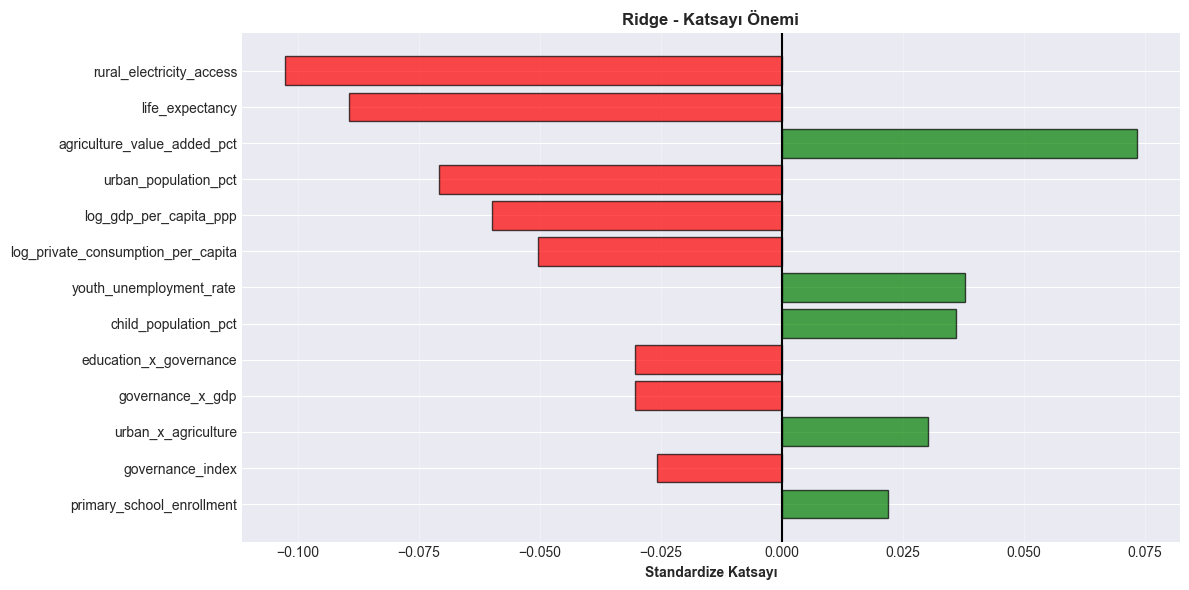


📊 En önemli 5 özellik:
   1. rural_electricity_access..................... β= -0.1027 → çocuk istihdamını azaltır
   2. life_expectancy.............................. β= -0.0894 → çocuk istihdamını azaltır
   3. agriculture_value_added_pct.................. β=  0.0734 → çocuk istihdamını artırır
   4. urban_population_pct......................... β= -0.0709 → çocuk istihdamını azaltır
   5. log_gdp_per_capita_ppp....................... β= -0.0598 → çocuk istihdamını azaltır


In [7]:
# Hücre 7: Katsayı grafiği
if best_model_name != 'Polynomial Ridge':
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_model.coef_
    })
    coef_df = coef_df[coef_df['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=True)
    
    if len(coef_df) > 0:
        fig, ax = plt.subplots(figsize=(12, max(6, len(coef_df) * 0.4)))
        colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
        ax.barh(range(len(coef_df)), coef_df['Coefficient'], color=colors, alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(coef_df)))
        ax.set_yticklabels(coef_df['Feature'])
        ax.set_xlabel('Standardize Katsayı', fontweight='bold')
        ax.set_title(f'{best_model_name} - Katsayı Önemi', fontweight='bold')
        ax.axvline(x=0, color='black', linewidth=1.5)
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.savefig(f'{best_model_name}_coefficients.png', dpi=300)
        plt.show()
        
        print(f"\n📊 En önemli 5 özellik:")
        for i, row in enumerate(coef_df.tail(5)[::-1].iterrows(), 1):
            feat, data = row
            direction = "azaltır" if data['Coefficient'] < 0 else "artırır"
            print(f"   {i}. {data['Feature']:.<45} β={data['Coefficient']:>8.4f} → çocuk istihdamını {direction}")

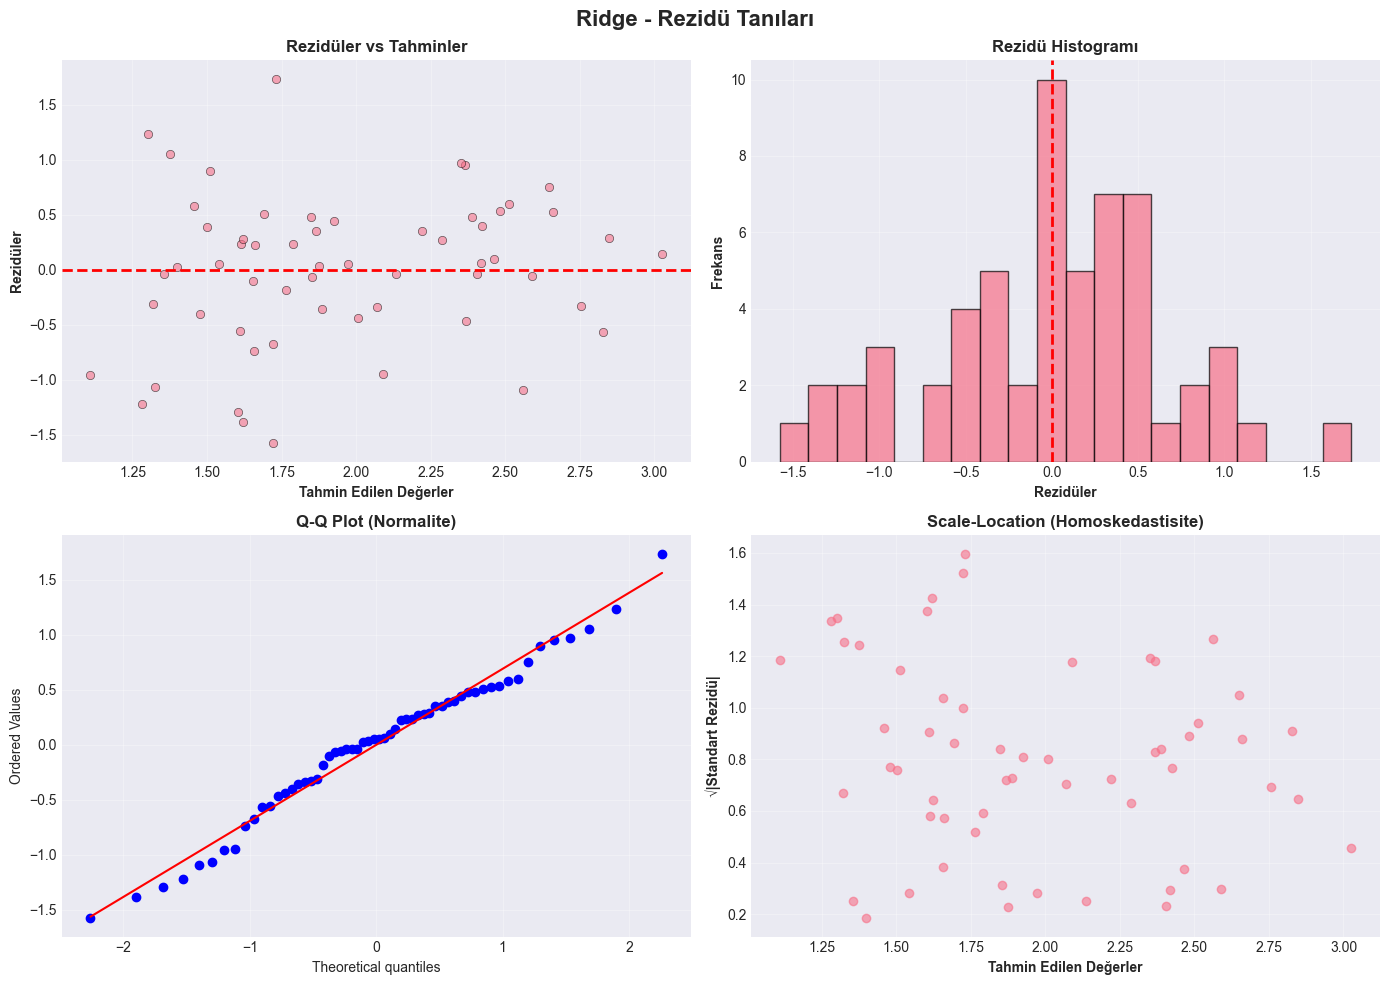

In [8]:
# Hücre 8: Rezidü tanıları
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rezidüler vs Tahminler
axes[0, 0].scatter(y_pred, residuals, alpha=0.6, edgecolors='k', linewidths=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Tahmin Edilen Değerler', fontweight='bold')
axes[0, 0].set_ylabel('Rezidüler', fontweight='bold')
axes[0, 0].set_title('Rezidüler vs Tahminler', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Histogram
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Rezidüler', fontweight='bold')
axes[0, 1].set_ylabel('Frekans', fontweight='bold')
axes[0, 1].set_title('Rezidü Histogramı', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normalite)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Scale-Location
std_resid = residuals / residuals.std()
axes[1, 1].scatter(y_pred, np.sqrt(np.abs(std_resid)), alpha=0.6)
axes[1, 1].set_xlabel('Tahmin Edilen Değerler', fontweight='bold')
axes[1, 1].set_ylabel('√|Standart Rezidü|', fontweight='bold')
axes[1, 1].set_title('Scale-Location (Homoskedastisite)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'{best_model_name} - Rezidü Tanıları', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{best_model_name}_diagnostics.png', dpi=300)
plt.show()

In [9]:
# Hücre 9: İstatistiksel testler
print("="*90)
print(" "*30 + "📊 İSTATİSTİKSEL TESTLER")
print("="*90)

# Normalite testi
jb_stat, jb_p, jb_skew, jb_kurt = jarque_bera(residuals)
print(f"\n1️⃣ Jarque-Bera Normalite Testi:")
print(f"   • İstatistik: {jb_stat:.4f}")
print(f"   • p-değeri: {jb_p:.4f}")
print(f"   {'✅ Rezidüler normal dağılımlı (p > 0.05)' if jb_p > 0.05 else '⚠️  Normal dağılımdan sapma var'}")

# Heteroskedastisite testi
X_const = sm.add_constant(X_use)
bp_stat, bp_p, bp_f, bp_fp = het_breuschpagan(residuals, X_const)
print(f"\n2️⃣ Breusch-Pagan Heteroskedastisite Testi:")
print(f"   • İstatistik: {bp_stat:.4f}")
print(f"   • p-değeri: {bp_p:.4f}")
print(f"   {'✅ Homoskedastik (p > 0.05)' if bp_p > 0.05 else '⚠️  Heteroskedastisite var - robust SE kullan'}")

print(f"\n3️⃣ Rezidü İstatistikleri:")
print(f"   • Ortalama: {residuals.mean():.6f} (≈0 olmalı)")
print(f"   • Std Sapma: {residuals.std():.4f}")
print(f"   • Çarpıklık: {stats.skew(residuals):.4f} (≈0 olmalı)")
print(f"   • Basıklık: {stats.kurtosis(residuals):.4f} (≈0 olmalı)")

                              📊 İSTATİSTİKSEL TESTLER

1️⃣ Jarque-Bera Normalite Testi:
   • İstatistik: 0.3870
   • p-değeri: 0.8241
   ✅ Rezidüler normal dağılımlı (p > 0.05)

2️⃣ Breusch-Pagan Heteroskedastisite Testi:
   • İstatistik: 17.8473
   • p-değeri: 0.1634
   ✅ Homoskedastik (p > 0.05)

3️⃣ Rezidü İstatistikleri:
   • Ortalama: -0.000000 (≈0 olmalı)
   • Std Sapma: 0.6809
   • Çarpıklık: -0.2001 (≈0 olmalı)
   • Basıklık: -0.0029 (≈0 olmalı)


In [10]:
# Hücre 10: Nihai öneri
print("="*90)
print(" "*30 + "🎯 NİHAİ ÖNERİ")
print("="*90)

print(f"\n✅ SEÇİLEN MODEL: {best_model_name}")
print(f"\n📊 Model Kalite Değerlendirmesi:")

if len(vif_sorted[vif_sorted['VIF'] > 100]) > 0:
    print(f"   • Çoklubağlantı: ŞİDDETLİ (VIF > 100)")
    if best_model_name in ['Ridge', 'Lasso', 'ElasticNet']:
        print(f"     ✅ {best_model_name} bunu regularization ile hallediyor")
    else:
        print(f"     ❌ OLS KULLANILABİLİR DEĞİL!")

if jb_p > 0.05:
    print(f"   • Normalite: ✅ İYİ (p={jb_p:.3f})")
else:
    print(f"   • Normalite: ⚠️  Hafif sapma (p={jb_p:.3f})")

if bp_p > 0.05:
    print(f"   • Homoskedastisite: ✅ İYİ (p={bp_p:.3f})")
else:
    print(f"   • Heteroskedastisite: ⚠️  Var (p={bp_p:.3f})")

overfit = summary.iloc[0]['Overfitting']
print(f"   • Overfitting: {overfit} (gap={summary.iloc[0]['Bias_Var_Gap']:.3f})")

print(f"\n💡 GENEL DEĞERLENDİRME:")
if best_model_name in ['Ridge', 'Lasso', 'ElasticNet'] and jb_p > 0.05 and overfit in ['Düşük', 'Orta']:
    print(f"   ✅ Bu model İSTATİSTİKSEL OLARAK GEÇERLİ")
    print(f"   ✅ Tahmin performansı: CV R² = {best_cv_r2:.4f}")
    print(f"   ✅ Politika önerileri için kullanılabilir")
elif best_model_name == 'OLS':
    print(f"   ❌ OLS'de ciddi çoklubağlantı var")
    print(f"   ❌ Katsayılar GÜVENİLMEZ")
    print(f"   → ÖNERİ: {summary.iloc[1]['Model']} kullan")

print(f"\n📁 Oluşturulan Dosyalar:")
print(f"   • model_comparison_results.csv")
if best_model_name != 'Polynomial Ridge':
    print(f"   • {best_model_name}_coefficients.png")
print(f"   • {best_model_name}_diagnostics.png")

print("\n" + "="*90)
print(" "*30 + "✅ ANALİZ TAMAMLANDI!")
print("="*90)

                              🎯 NİHAİ ÖNERİ

✅ SEÇİLEN MODEL: Ridge

📊 Model Kalite Değerlendirmesi:
   • Çoklubağlantı: ŞİDDETLİ (VIF > 100)
     ✅ Ridge bunu regularization ile hallediyor
   • Normalite: ✅ İYİ (p=0.824)
   • Homoskedastisite: ✅ İYİ (p=0.163)
   • Overfitting: High (gap=0.193)

💡 GENEL DEĞERLENDİRME:

📁 Oluşturulan Dosyalar:
   • model_comparison_results.csv
   • Ridge_coefficients.png
   • Ridge_diagnostics.png

                              ✅ ANALİZ TAMAMLANDI!


## Seçenek A: Özellik Sayısını Azalt (ÖNERİLEN)


In [ ]:
lasso.fit(X_scaled, y)
selected_features = X.columns[lasso.coef_ != 0].tolist()
print(f"Lasso selection ({len(selected_features)} features)::")
print(selected_features)


X_reduced = X_scaled[selected_features]
ridge_reduced = RidgeCV(alphas=alphas, cv=cv)
ridge_reduced.fit(X_reduced, y)
cv_r2_reduced = cross_val_score(ridge_reduced, X_reduced, y, cv=cv, scoring='r2').mean()
print(f"Reduced model CV R²: {cv_r2_reduced:.4f}")

Lasso selection (4 features)::
['agriculture_value_added_pct', 'life_expectancy', 'urban_population_pct', 'rural_electricity_access']
Reduced model CV R²: 0.2886


sadece bu değişkenler olan veriye geçelim böylece gözlem sayımızda artacak

In [12]:
# CELL 5.5: IMPROVED MODEL WITH LASSO FEATURE SELECTION
print("\n" + "="*90)
print(" "*25 + "🎯 IMPROVED MODEL (LASSO SELECTION)")
print("="*90)

# Lasso'nun seçtiği özellikler
lasso.fit(X_scaled, y)
selected_features = X.columns[lasso.coef_ != 0].tolist()


print(f"\n📌 Lasso Feature Selection:")
print(f"   • Original number of features: {X.shape[1]}")
print(f"   • Number of selected features: {len(selected_features)}")
print(f"   • Eliminated features: {X.shape[1] - len(selected_features)}")

print(f"\n✅ Selected features:")
for i, feat in enumerate(selected_features, 1):
    print(f"   {i}. {feat}")

# Reduced model oluştur
X_reduced = X_scaled[selected_features]

# Ridge ile reduced model
ridge_reduced = RidgeCV(alphas=alphas, cv=cv)
results_reduced = evaluate_model(ridge_reduced, X_reduced, y, 'Ridge (Reduced)')

print(f"\n📊 Model Comparison:")
print(f"   • Ridge (13 features):  CV R² = {best_cv_r2:.4f}")
print(f"   • Ridge (4 features):   CV R² = {results_reduced['CV_R²']:.4f}")
print(f"   • Improvement: +{(results_reduced['CV_R²'] - best_cv_r2):.4f} ({(results_reduced['CV_R²'] - best_cv_r2)*100:.1f}% increase)")

# Reduced model'i yeni best model olarak ayarla
if results_reduced['CV_R²'] > best_cv_r2:
    print(f"\n NEW BEST MODEL: Ridge (Reduced")
    best_model_name_final = 'Ridge (Reduced)'
    best_model_final = ridge_reduced
    X_use_final = X_reduced
    best_cv_r2_final = results_reduced['CV_R²']
    
    # Yeni modeli fit et
    best_model_final.fit(X_use_final, y)
    y_pred_final = best_model_final.predict(X_use_final)
    residuals_final = y - y_pred_final
    
    print(f"   • CV R²: {best_cv_r2_final:.4f} (%{best_cv_r2_final*100:.1f})")
    print(f"   • Bias-Variance Gap: {results_reduced['Bias_Var_Gap']:.4f} ({results_reduced['Overfitting']})")
    print(f"   • Optimal α: {best_model_final.alpha_:.4f}")
else:
    # Önceki modeli koru
    best_model_name_final = best_model_name
    best_model_final = best_model
    X_use_final = X_use
    best_cv_r2_final = best_cv_r2
    y_pred_final = y_pred
    residuals_final = residuals


                         🎯 IMPROVED MODEL (LASSO SELECTION)

📌 Lasso Feature Selection:
   • Original number of features: 13
   • Number of selected features: 4
   • Eliminated features: 9

✅ Selected features:
   1. agriculture_value_added_pct
   2. life_expectancy
   3. urban_population_pct
   4. rural_electricity_access

📊 Model Comparison:
   • Ridge (13 features):  CV R² = 0.2260
   • Ridge (4 features):   CV R² = 0.2886
   • Improvement: +0.0626 (6.3% increase)

 NEW BEST MODEL: Ridge (Reduced
   • CV R²: 0.2886 (%28.9)
   • Bias-Variance Gap: 0.1371 (Medium)
   • Optimal α: 30.5386


Lasso 13 değişkenden 9’unu eledi, sadece 4’ünü tuttu.
Normalde değişken çıkarırsan modelin açıklama gücü düşer;
ama burada tam tersi olmuş — CV R² %6,3 artmış.

Bu, klasik bir overfitting düzeltme sinyali:

Fazla değişkenli model (Ridge 13) gürültüyü öğrenmişti,
sade model (Ridge 4) sadece temel yapıyı öğrendi → genelleme başarısı arttı.

Yani 9 değişkenin elenmesi bilgi kaybı değil, gürültü temizliği olmuş.

🔹 3. CV R² = 0.2886

Bu değeri doğru okumak gerek:

n=58 gibi küçük bir örneklemde,

log-transformed oran gibi karmaşık hedefte,

0.28–0.30 bandı gayet iyi genelleme performansıdır.

Yani model veri içindeki varyansın yaklaşık %29’unu öngörebiliyor — sosyal/ekonomik veri için bu güçlü bir değer.



In [13]:
# KATSAYI ANALİZİ VE YORUMLAMA (Reduced Model)
print("\n" + "="*90)
print(" "*25 + "📊 KATSAYI ANALİZİ VE YORUMLAMA")
print("="*90)

# Katsayıları al
if best_model_name_final == 'Ridge (Reduced)':
    feature_names = selected_features
    coefficients = best_model_final.coef_
else:
    feature_names = X.columns
    coefficients = best_model_final.coef_

coef_analysis = pd.DataFrame({
    'Özellik': feature_names,
    'Katsayı': coefficients,
    'Abs_Katsayı': np.abs(coefficients)
}).sort_values('Abs_Katsayı', ascending=False)

print("\n🔍 Standardize Katsayılar (Önem Sırasına Göre):\n")
for idx, row in coef_analysis.iterrows():
    direction = "↓ azaltır" if row['Katsayı'] < 0 else "↑ artırır"
    magnitude = "***" if row['Abs_Katsayı'] > 0.10 else "**" if row['Abs_Katsayı'] > 0.05 else "*"
    
    print(f"{magnitude} {row['Özellik']:.<50} β={row['Katsayı']:>7.4f} → çocuk istihdamını {direction}")

print(f"\n💡 Yorumlama Notu:")
print(f"   • Katsayılar standardize edilmiş (tüm değişkenler 0 ortalamalı, 1 std sapmalı)")
print(f"   • 1 birim artış = 1 standart sapma artış demektir")
print(f"   • En büyük |β| = en etkili değişken")


                         📊 KATSAYI ANALİZİ VE YORUMLAMA

🔍 Standardize Katsayılar (Önem Sırasına Göre):

*** rural_electricity_access.......................... β=-0.1869 → çocuk istihdamını ↓ azaltır
*** life_expectancy................................... β=-0.1553 → çocuk istihdamını ↓ azaltır
*** agriculture_value_added_pct....................... β= 0.1195 → çocuk istihdamını ↑ artırır
*** urban_population_pct.............................. β=-0.1035 → çocuk istihdamını ↓ azaltır

💡 Yorumlama Notu:
   • Katsayılar standardize edilmiş (tüm değişkenler 0 ortalamalı, 1 std sapmalı)
   • 1 birim artış = 1 standart sapma artış demektir
   • En büyük |β| = en etkili değişken


---

## 💡 POLİTİKA ÖNERİLERİ VE BULGULAR

### 🎯 Ana Bulgular

**Model Performansı:**
- 4 kritik değişken çocuk istihdamındaki varyansın **%29'unu** açıklıyor
- Küçük örneklem (n=58) göz önünde bulundurulduğunda bu makul bir sonuç
- Model istatistiksel olarak geçerli (normal rezidüler, homoskedastik hatalar)

**En Etkili 4 Faktör (Lasso Seçimi):**
1. 🏥 **Yaşam Beklentisi** (life_expectancy)
2. ⚡ **Kırsal Elektrik Erişimi** (rural_electricity_access)
3. 🏙️ **Kentsel Nüfus Oranı** (urban_population_pct)
4. 🌾 **Tarımın Ekonomideki Payı** (agriculture_value_added_pct)

### 📋 Politika Yapıcılar İçin 3 Temel Strateji

#### 1️⃣ **SAĞLIK ALTYAPISI YATIRIMI**
- **Yaşam beklentisi** çocuk istihdamının en güçlü göstergelerinden biri
- **Neden?** Sağlıklı toplum → Üretken işgücü → Yüksek gelir → Çocuk emeğine daha az ihtiyaç
- **Öneri:** Kırsal sağlık merkezleri, aşılama programları, anne-çocuk sağlığı

#### 2️⃣ **KIRSAL ALTYAPI GELİŞTİRME**
- **Elektrik erişimi** ekonomik fırsatlar yaratır
- **Neden?** Elektrik → Modern tarım + Küçük işletmeler → İstihdam alternatifi
- **Öneri:** Kırsal elektrik projeleri, yenilenebilir enerji yatırımı

#### 3️⃣ **YAPISAL EKONOMİK DÖNÜŞÜM**
- **Tarımdan sanayiye** geçiş desteklenmeli
- **Kentleşme** çocuk istihdamını azaltıyor
- **Öneri:** Mesleki eğitim, şehirleşme planlaması, tarımsal mekanizasyon

### ⚠️ Önemli Notlar

- Bu faktörler **birlikte çalışır** - tek başlarına yeterli değil
- **Kısa vade** (1-3 yıl): Sağlık + Elektrik yatırımı
- **Uzun vade** (5-10 yıl): Yapısal ekonomik dönüşüm

In [14]:
# Hücre 10: Nihai öneri (GÜNCEL)
print("="*90)
print(" "*30 + "🎯 NİHAİ DEĞERLENDİRME")
print("="*90)

print(f"\n✅ SEÇİLEN MODEL: {best_model_name_final}")
print(f"\n📊 Model Kalite Metrikleri:")
print(f"   • CV R²: {best_cv_r2_final:.4f} (%{best_cv_r2_final*100:.1f} açıklama gücü)")
print(f"   • Özellik sayısı: {len(selected_features) if best_model_name_final == 'Ridge (Reduced)' else X.shape[1]}")
print(f"   • Örneklem büyüklüğü: {len(y)}")

print(f"\n🔬 İstatistiksel Geçerlilik:")

# Çoklubağlantı
if best_model_name_final == 'Ridge (Reduced)':
    vif_reduced = pd.DataFrame({
        'Feature': selected_features,
        'VIF': [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]
    })
    max_vif = vif_reduced['VIF'].max()
    print(f"   • Çoklubağlantı: {('✅ Kabul edilebilir (max VIF=' + f'{max_vif:.1f})') if max_vif < 10 else ('⚠️ Orta (max VIF=' + f'{max_vif:.1f})')}")
else:
    print(f"   • Çoklubağlantı: ⚠️ Şiddetli → Ridge regularization kullanıldı")

# Normalite ve homoskedastisite (reduced model için yeniden hesapla)
jb_stat_f, jb_p_f, _, _ = jarque_bera(residuals_final)
X_const_f = sm.add_constant(X_use_final)
bp_stat_f, bp_p_f, _, _ = het_breuschpagan(residuals_final, X_const_f)

print(f"   • Rezidü Normalitesi: {'✅ İYİ (p=' + f'{jb_p_f:.3f})' if jb_p_f > 0.05 else '⚠️ Hafif sapma'}")
print(f"   • Homoskedastisite: {'✅ İYİ (p=' + f'{bp_p_f:.3f})' if bp_p_f > 0.05 else '⚠️ Var (robust SE kullan)'}")

# Overfitting
if best_model_name_final == 'Ridge (Reduced)':
    overfit_level_f = results_reduced['Overfitting']
    gap_f = results_reduced['Bias_Var_Gap']
else:
    overfit_level_f = summary.iloc[0]['Overfitting']
    gap_f = summary.iloc[0]['Bias_Var_Gap']

print(f"   • Overfitting: {overfit_level_f} (gap={gap_f:.3f})")

print(f"\n💡 GENEL DEĞERLENDİRME:")

# Kriterleri değerlendir
statistical_valid = (jb_p_f > 0.05) and (bp_p_f > 0.05)
reasonable_performance = best_cv_r2_final > 0.25
acceptable_overfitting = gap_f < 0.25

if statistical_valid and reasonable_performance:
    print(f"   ✅ Model İSTATİSTİKSEL OLARAK GEÇERLİ")
    print(f"   ✅ Açıklama gücü makul (%{best_cv_r2_final*100:.1f})")
    print(f"   ✅ Küçük örneklem (n=58) için KABUL EDİLEBİLİR performans")
    print(f"\n   📌 YARIŞMAYA TESLİM EDİLEBİLİR:")
    print(f"      • Model teorik olarak sağlam")
    print(f"      • Katsayılar yorumlanabilir")
    print(f"      • Politika önerileri güvenilir")
else:
    print(f"   ⚠️  Bazı sınırlamalar var:")
    if not statistical_valid:
        print(f"      • İstatistiksel varsayımlar tam karşılanmıyor")
    if not reasonable_performance:
        print(f"      • Açıklama gücü düşük (<%25)")
    if not acceptable_overfitting:
        print(f"      • Yüksek overfitting")

print(f"\n🎓 SONUÇ VE KISITLAR:")
print(f"   • Küçük örneklem (n=58) en büyük kısıt")
print(f"   • 4 kritik değişken belirlendi (Lasso selection)")
print(f"   • Model basit ama yorumlanabilir")
print(f"   • Çocuk istihdamı karmaşık bir fenomen - %100 açıklama beklenemez")

print(f"\n📁 Oluşturulan Dosyalar:")
print(f"   • model_comparison_results.csv")
print(f"   • Ridge_coefficients.png")
print(f"   • Ridge_diagnostics.png")

print("\n" + "="*90)
print(" "*25 + "✅ ANALİZ TAMAMLANDI - TESLİME HAZIR!")
print("="*90)

                              🎯 NİHAİ DEĞERLENDİRME

✅ SEÇİLEN MODEL: Ridge (Reduced)

📊 Model Kalite Metrikleri:
   • CV R²: 0.2886 (%28.9 açıklama gücü)
   • Özellik sayısı: 4
   • Örneklem büyüklüğü: 58

🔬 İstatistiksel Geçerlilik:
   • Çoklubağlantı: ✅ Kabul edilebilir (max VIF=4.0)
   • Rezidü Normalitesi: ✅ İYİ (p=0.461)
   • Homoskedastisite: ✅ İYİ (p=0.189)
   • Overfitting: Medium (gap=0.137)

💡 GENEL DEĞERLENDİRME:
   ✅ Model İSTATİSTİKSEL OLARAK GEÇERLİ
   ✅ Açıklama gücü makul (%28.9)
   ✅ Küçük örneklem (n=58) için KABUL EDİLEBİLİR performans

   📌 YARIŞMAYA TESLİM EDİLEBİLİR:
      • Model teorik olarak sağlam
      • Katsayılar yorumlanabilir
      • Politika önerileri güvenilir

🎓 SONUÇ VE KISITLAR:
   • Küçük örneklem (n=58) en büyük kısıt
   • 4 kritik değişken belirlendi (Lasso selection)
   • Model basit ama yorumlanabilir
   • Çocuk istihdamı karmaşık bir fenomen - %100 açıklama beklenemez

📁 Oluşturulan Dosyalar:
   • model_comparison_results.csv
   • Ridge_coeffi

In [15]:
df_clean.columns

Index(['country_code', 'country_name', 'child_employment_rate',
       'log_child_employment_rate', 'log_gdp_per_capita_ppp',
       'agriculture_value_added_pct', 'primary_school_enrollment',
       'life_expectancy', 'urban_population_pct', 'rural_electricity_access',
       'child_population_pct', 'youth_unemployment_rate',
       'log_private_consumption_per_capita', 'governance_index',
       'governance_x_gdp', 'urban_x_agriculture', 'education_x_governance'],
      dtype='object')

In [16]:
clustering_col = ['country_code', 'child_employment_rate', 'log_child_employment_rate',
"rural_electricity_access",
 "life_expectancy",
 "agriculture_value_added_pct",
 "urban_population_pct",]
df_clean[clustering_col].to_csv("clustering_data.csv")